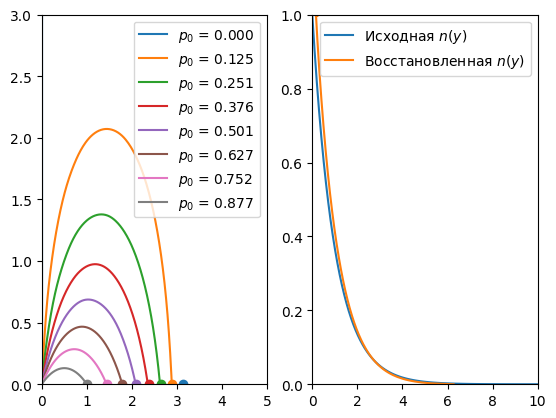

In [9]:
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad, simpson
from scipy.integrate import solve_ivp


def n(y: float) -> float:
    return np.exp(-y)


def dn_dy(y: float) -> float:
    return -np.exp(-y)


def n_inverse(p):
    return -np.log(p)


def integral_forward(y, p):
    return 1 / np.sqrt(n(y) ** 2 - p**2)


def x_p(p):
    return 2 * p * quad(integral_forward, 0.0, n_inverse(p), args=p, limit=1000)[0]


# Правая часть системы ДУ:
#
# Здесь f[0] = x, f[1] = y, f[2] = p, f[3] = q.
def sys_rhs(_t, f):
    return [
        f[2] / (n(f[1]) ** 2 + 1e-10),  # dx / dt = p / (n(y))^2
        f[3] / (n(f[1]) ** 2 + 1e-10),  # dy / dt = q / (n(y))^2
        0.0,  # dp / dt = 0
        dn_dy(f[1]) / (n(f[1]) + 1e-10),  # dq / dt = 1 / n(y) * [dn(y) / dy]
    ]


# --- Обратная задача ---
eps = 10.0 ** (-6)

p_0_variants = np.linspace(eps, n(0) - eps, 400)
x_0 = 0.0
y_0 = 0.0

# Значения X(p) для разных p_0 из списка p_0_variants.
x_p_values = {}
for p_0 in p_0_variants:
    x_p_values[p_0] = x_p(p_0)

fx, [ax1, ax2] = plt.subplots(1, 2)

ax1.set_xlim(0, 5)
ax1.set_ylim(0, 3)
t_start = 0
t_end = 3

for p_0 in p_0_variants[::50]:
    q_0 = math.sqrt(n(0) ** 2 - p_0**2)
    # print(p_0)
    result = solve_ivp(
        fun=sys_rhs,
        t_span=(t_start, t_end),
        t_eval=np.linspace(t_start, t_end, 1000),
        y0=[x_0, y_0, p_0, q_0],
    )
    ax1.plot(result.y[0], result.y[1], label=f"$p_0$ = {p_0:.3f}")
    ax1.scatter(x_p_values[p_0], 0)  # точки возврата
ax1.legend()
n_inverse_reconstructed = []
inf = 200

for i, r in enumerate(p_0_variants):
    func = [
        1.0 / math.pi * x_p_values[p_0] / np.sqrt(p_0**2 - r**2 + 1e-10)
        for p_0 in p_0_variants[i:]
    ]
    func[func == np.inf] = inf
    n_inverse_reconstructed.append(simpson(y=func, x=p_0_variants[i:]))

x = np.linspace(0, 10, 100)
ax2.plot(x, n(x), label="Исходная $n(y)$")
ax2.plot(n_inverse_reconstructed, p_0_variants, label="Восстановленная $n(y)$")

ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1)

ax2.legend()
plt.show()